# Исследование действия противотревожных препаратов

Данные - https://www.kaggle.com/steveahn/memory-test-on-drugged-islanders-data

В наборе представлены результаты эксперимента по изучению влияния противотревожных препаратов на память человека. В процессе эксперимента испытуемые проходили тест на память, затем в них вызывали либо счастливые, либо грустные воспоминания, после этого испытуемые принимали определнные препараты и снова проходили похожий тест.

В исследовании поставлены следующие вопросы:
1. Как противотревожные препараты влияют на деятельность памяти человека?
2. Как противотревожные препараты влияют на человека относительно его возраста?
3. Существует ли уровень (и какой, если существует) принятия препаратов, при котором их действие перестает проявляться?

In [48]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

## Изучение данных

In [2]:
data = pd.read_csv('Islander_data.csv',header=0)
print('Number of observations: ',data.age.size)
data.head()

Number of observations:  198


,first_name,last_name,age,Happy_Sad_group,Dosage,Drug,Mem_Score_Before,Mem_Score_After,Diff
0,Bastian,Carrasco,25,H,1,A,63.5,61.2,-2.3
1,Evan,Carrasco,52,S,1,A,41.6,40.7,-0.9
2,Florencia,Carrasco,29,H,1,A,59.7,55.1,-4.6
3,Holly,Carrasco,50,S,1,A,51.7,51.2,-0.5
4,Justin,Carrasco,52,H,1,A,47.0,47.1,0.1


Описание признаков:
* first_name - первое имя испытуемого;
* last_name - последнее имя испытуемого;
* age - возраст испытуемого;
* Happy_Sad_group - какие воспоминания были вызваны в процессе проведения эксперимена (H - счастливые, S - грустные);
* Dosage - доза, которую приянл испытуемый (для алпразолама: 1 мг, 3 мг, 5 мг; для триазолама: 0.25 мг, 0.5 мг, 0.75 мг; для плацебо: 1 таблетка, 2 таблетки, 3 таблетки);
* Drug - лекарство, которое принимал испытуемый (A - алпразолам, T - триазолам, S - сахарная таблетка, плацебо)
* Mem_Score_Before - количество секунд, которое потребовалось испытуемому, чтобы завершить тест на память до принятия лекарств;
* Mem_score_After - количество секунд, которое потребовалось испытуемому, чтобы завершить тест на память после принятия лекарств;
* Diff - разница в секундах.

In [3]:
data.isnull().sum()

first_name          0
last_name           0
age                 0
Happy_Sad_group     0
Dosage              0
Drug                0
Mem_Score_Before    0
Mem_Score_After     0
Diff                0
dtype: int64

В данных отсутствуют пропуски. Посмотрим на распределение непрерывных признаков.

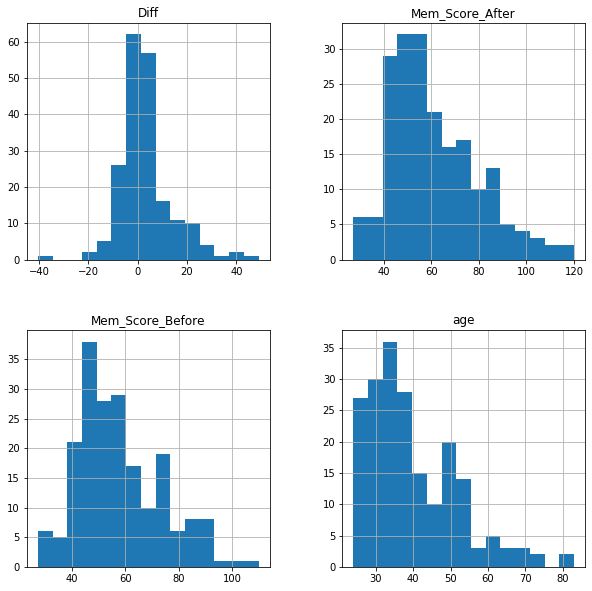

In [4]:
data[['age','Mem_Score_Before','Mem_Score_After','Diff']].hist(bins=15, figsize=(10,10))
plt.show()

Распределение возраста и счета до/после сильно отличается от нормального (в частности, "обрезанным" левым хвостом). При работе с этими признаками будут применяться непараметрические критерии.

Проверим данные на сбалансированность.

In [5]:
grouped = data.groupby('Drug')
grouped.size()

Drug
A    67
S    66
T    65
dtype: int64

In [6]:
grouped['Dosage'].value_counts()

Drug  Dosage
A     1         23
      2         22
      3         22
S     1         22
      2         22
      3         22
T     1         22
      2         22
      3         21
Name: Dosage, dtype: int64

In [7]:
grouped['Happy_Sad_group'].value_counts()

Drug  Happy_Sad_group
A     S                  34
      H                  33
S     H                  33
      S                  33
T     H                  33
      S                  32
Name: Happy_Sad_group, dtype: int64

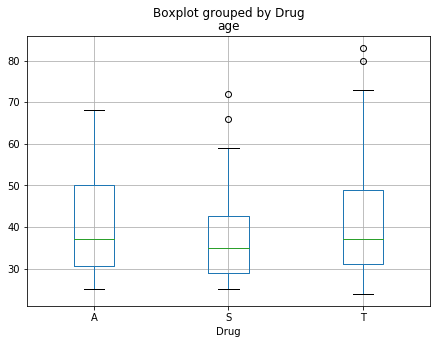

Pvalue for Kruskal test:  0.351917374539384


In [8]:
data.boxplot(column='age',by='Drug',figsize=(7,5))
plt.show()

_, pval = stats.kruskal(data[data.Drug == 'A'].age,data[data.Drug == 'S'].age,data[data.Drug == 'T'].age)
print("Pvalue for Kruskal test: ", pval)

Выборки по каждому лекарству примерно одного размера, признаки дозирования, вызванных воспоминаний и возраста распределены в подгруппах максимально равномерно. Также проверим распределение оценки теста до приянтия лекарств, чтобы показать, что ни у какой группы не было изначально примущества в результатах.

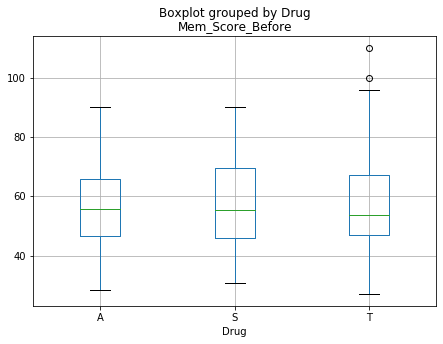

Pvalues for Kruskal test:  0.8443761684234427


In [9]:
data.boxplot(column='Mem_Score_Before',by='Drug',figsize=(7,5))
plt.show()

_, pval = stats.kruskal(data[data.Drug == 'A'].Mem_Score_Before,data[data.Drug == 'S'].Mem_Score_Before,
                         data[data.Drug == 'T'].Mem_Score_Before)
print("Pvalues for Kruskal test: ", pval)

Начальные результаты в группах распределены примерно одинаково.

## Проверка гипотез

Для начала проверим, правильно ли посчитана разница между результатами до и после принятия лекарств

In [64]:
print(((data['Mem_Score_After'] - data['Mem_Score_Before']) == data['Diff']).mean())
print(abs((data['Mem_Score_After'] - data['Mem_Score_Before']) - data['Diff']).mean())

0.2777777777777778
2.8155087688884178e-15


Как видмим, полное совпадение лишь в 27% случаев, однако среднее различие крайне мало. Скорее всего, это связано с особенностями вычислительных систем, на которых формировался датасет и проводится анализ. Будем использовать данные, предоставленные в таблице.

Для начала посмотрим, значимы ли изменения в результатах тестов по всей выборке.

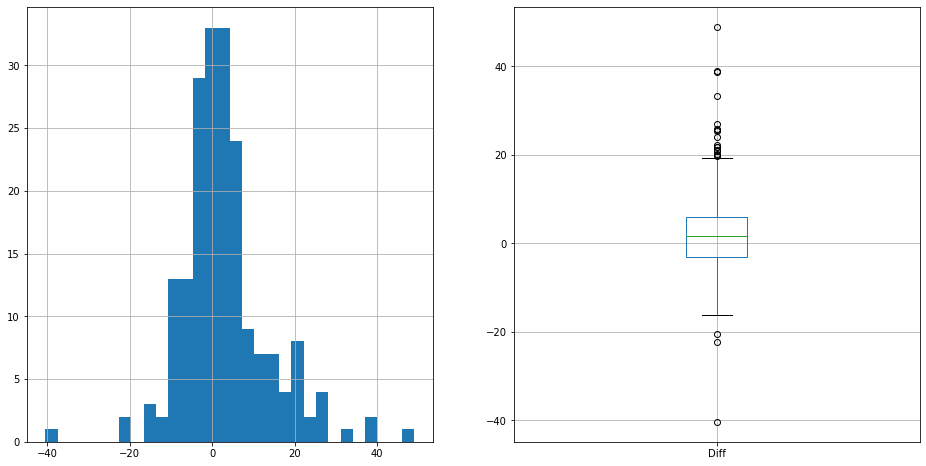

In [41]:
plt.figure(figsize=(16,8))
plt.subplot(121)
data.Diff.hist(bins=30)
plt.subplot(122)
data.boxplot(column='Diff')
plt.show()

In [11]:
print('Mean difference: ', data.Diff.mean())
print('Confidence interval for mean: ',
      stats.t.interval(0.95, len(data.Diff), loc=data.Diff.mean(), scale=stats.sem(data.Diff)))

Mean difference:  2.954545454545455
Confidence interval for mean:  (1.4473397436683213, 4.461751165422589)


95% доверительный интервал не содержит 0 и полностьюе положителен - значит, в целом применение противотревожных лекарств способствует улучшению памяти. Проверим распределение различий в результатах тестов на нормальность, чтобы определиться с используемыми методами.

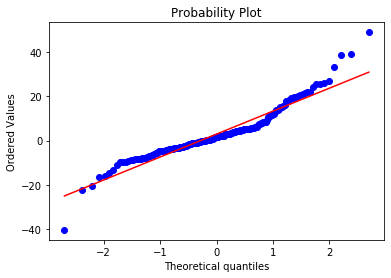

Pvalue for Jarque-Bera:  (107.03064200936136, 0.0)
Pvalue for Shapiro-Wilk:  (0.9224395751953125, 1.0078899492782512e-08)


In [12]:
stats.probplot(data.Diff, dist='norm', plot=plt)
plt.show()

print('Pvalue for Jarque-Bera: ', stats.jarque_bera(data.Diff))
print('Pvalue for Shapiro-Wilk: ', stats.shapiro(data.Diff))

Критерии говорят о том, что распределение не является нормальным, следовательно, желательнло использовать непараметрические критерии в дальнейшем анализе. Однако поскольку для многих методов анализа нет непараметрических альтернатив, то параметрические методы будут использоваться параллельно с непараметрическими.

In [13]:
# метод Даннета, используемый для сравнения подгрупп с плацебо
def Dunnet(control, sample1, *samples):
    full = np.hstack([control, sample1, *samples]) #создание полной выборки
    samples = [sample1, *samples] #список выборок для перебора
    ret = [] #возвращаемый результат
    for sample in samples:
        SE = np.sqrt(full.var()*(1/len(sample)+1/len(control)))
        D = (control.mean() - sample.mean())/SE
        p = 2*min(stats.t.cdf(D,len(full)),1-stats.t.cdf(D,len(full))) #двустороння альтерантива
        ret.append((D,p))
    return ret

In [14]:
#разбиение на выборки по лекарствам
placebo = data[data.Drug == 'S'] 
alprazolam = data[data.Drug == 'A']
triazolam = data[data.Drug == 'T']

In [46]:
print("Pvalue for Levene's test of equal variance: ",stats.levene(placebo.Diff,triazolam.Diff,alprazolam.Diff)[1])

Pvalue for Levene's test of equal variance:  2.7355222091967235e-08


Критерий Левена отвергает гипотезу о равенстве дисперсий в выборках, что вкупе с не нормальным распределением не позволяет использовать стандартную модель ANOVA. Лучшим вариантом в таком случае мне кажется проведение визуального анализа и точечной проверкой интересующих гипотез.

Посмотрим на то, как меняются распределения в зависимости от вида лекарства и его дозировки, а также проверим на равенство нулю средние выборок по лекарствам.

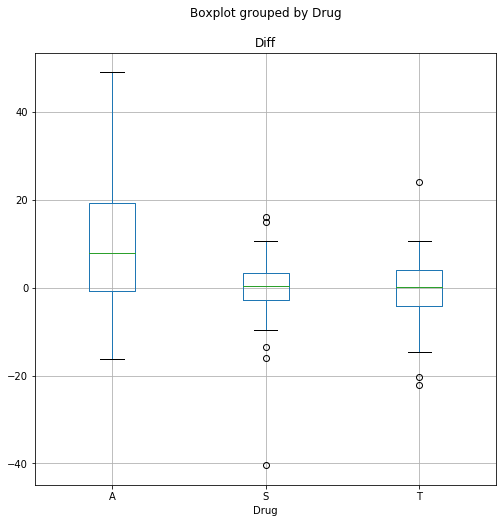

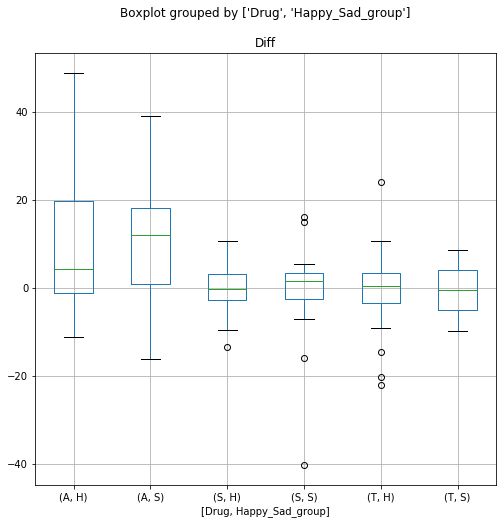

alprazolam pvalue for ttest:  1.6898179935298675e-07
triazolam pvalue for ttest:  0.5072224471243232
placebo pvalue for ttest:  0.8534459675334031


In [43]:
data.boxplot(column='Diff',by='Drug',figsize=(8,8))
data.boxplot(column='Diff',by=['Drug','Happy_Sad_group'],figsize=(8,8))
plt.show()

for name, sample in zip(['alprazolam', 'triazolam', 'placebo'],[alprazolam, triazolam, placebo]):
    print(name,'pvalue for ttest: ',stats.ttest_1samp(sample.Diff,0)[1])

Похоже, алпразолам - единственный, чье действие постоянно отлично от нуля. Тип воспоминаний, которые были вызваны перед принятием препарата, похоже, не влияют на результат тестов. Проверим формально, что действие препаратов отлично от дейтсвия плацебо методом Даннета.

In [16]:
dunnet_res = Dunnet(placebo.Diff, triazolam.Diff, alprazolam.Diff)
print("Pvalue of triazolam for Dunnet's test:", dunnet_res[0][1])
print("Pvalue of alprazolam for Dunnet's test:", dunnet_res[1][1])

Pvalue of triazolam for Dunnet's test: 0.824407737826993
Pvalue of alprazolam for Dunnet's test: 5.381270609161187e-07


Метод Даннета показывает, что триазолам по своему эффекту действует также, как плацебо, но действие алпразолама отличается. Отсюда можно сделать вывод о том, что *триазолам не оказывает существенного влияния на деятельность памяти человека*.

Проверим, влияют ли воспоминания на результат, проведя серию t-тестов.

In [20]:
for name, sample in zip(['alprazolam', 'triazolam', 'placebo'],[alprazolam, triazolam, placebo]):
    print("Group ",name)
    print('Pvalue for t-test: ',stats.ttest_ind(sample[sample.Happy_Sad_group == 'H'].Diff,sample[sample.Happy_Sad_group == 'S'].Diff)[1])
    print('Pvalue for Mann-Whiney test: ',stats.mannwhitneyu(sample[sample.Happy_Sad_group == 'H'].Diff,sample[sample.Happy_Sad_group == 'S'].Diff)[1],'\n')

Group  alprazolam
Pvalue for t-test:  0.504964382218464
Pvalue for Mann-Whiney test:  0.20213598374323283 

Group  triazolam
Pvalue for t-test:  0.6461192003846001
Pvalue for Mann-Whiney test:  0.20792906848764964 

Group  placebo
Pvalue for t-test:  0.8367474415505862
Pvalue for Mann-Whiney test:  0.3337149782093779 



Ни один из критериев не отвергает гипотезу о том, что воспоминания не влияют на результат тестов. Однако стоит заметить, что в эксперименте не было контрольной группы, для которой не вызывались бы определенные воспоминания, поэтому вывод следует сформулировать лседюущим образом: *тип воспоминаний, вызванных у испытуемого, не влияет на его результат*.

Изучим, изменяется ли влияние лекарств на человека с изменением его возраста.

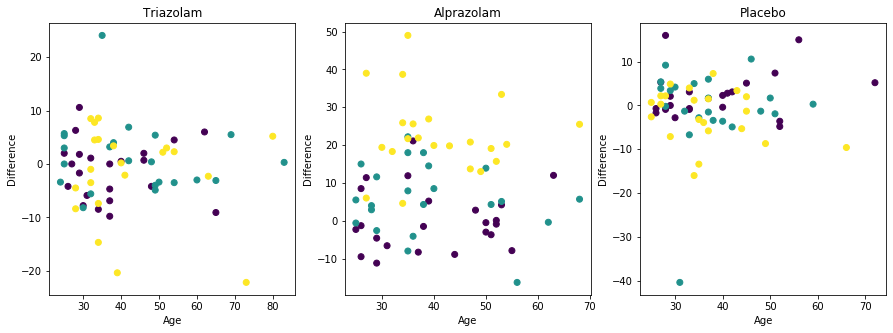

Correlation between age and diff in  alprazolam  :  (-0.01309413941758764, 0.9162428158448722)
Correlation between age and diff in  triazolam  :  (-0.08491970537446844, 0.5012166385048848)
Correlation between age and diff in  placebo  :  (0.022611055632909383, 0.856990594498974)


In [42]:
plt.figure(figsize=(15,5))
plt.subplot(131,title='Triazolam',xlabel='Age',ylabel='Difference')
plt.scatter(triazolam.age,triazolam.Diff,c=triazolam.Dosage)
plt.subplot(132,title='Alprazolam',xlabel='Age',ylabel='Difference')
plt.scatter(alprazolam.age,alprazolam.Diff,c=alprazolam.Dosage)
plt.subplot(133,title='Placebo',xlabel='Age',ylabel='Difference')
plt.scatter(placebo.age,placebo.Diff,c=placebo.Dosage)
plt.show()
for name , sample in zip(['alprazolam', 'triazolam', 'placebo'],[alprazolam, triazolam, placebo]):
    print('Correlation between age and diff in ',name,' : ',stats.pearsonr(sample.age,sample.Diff)) 

Все корреляции признаются незначимыми, однако для алпразолама заметно изменение зависимости "возраст-результат" от уровня дозировки. Проверим, изменяется ли результат пациентов в завиисмости от дозировки лекарства.

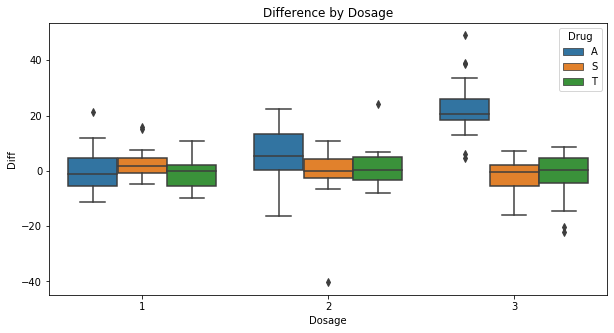

In [52]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data,y='Diff',x='Dosage',hue='Drug')
plt.title('Difference by Dosage')
plt.show()

In [53]:
for dose in range(1,4):
    print('Pvalue for ttest of dosge ',dose,':',stats.ttest_1samp(alprazolam[alprazolam.Dosage == dose].Diff,0)[1])

Pvalue for ttest of dosge  1 : 0.8616430319911088
Pvalue for ttest of dosge  2 : 0.006893335989012772
Pvalue for ttest of dosge  3 : 1.3532619415081942e-09


Дейтсвие триазолама и плацебо не зависит от дозировки, в то время как эффект от алпразолама не проявляется при минимальной доизровке, но заметен при повышенной.

Проверим, значима ли зависимость результатов от возраста с учетом разбиения по дозировке.

Correlation between age and difference in group with dosage 1 :  (0.06779689109477836, 0.7585661961260162)
Correlation between age and difference in group with dosage 2 :  (-0.19025807529856403, 0.3963904948642496)
Correlation between age and difference in group with dosage 3 :  (-0.08161876029354363, 0.7180374555108968)


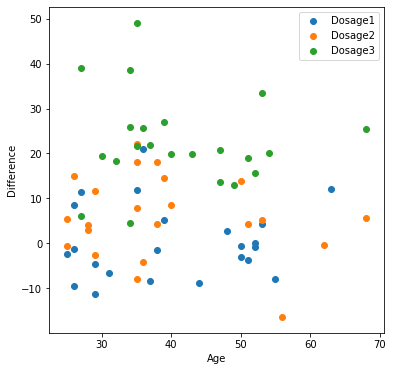

In [66]:
plt.figure(figsize=(6,6))
groups = alprazolam.groupby('Dosage')
for name, group in groups:
    plt.scatter(group.age,group.Diff,label='Dosage' + str(name))
    print('Correlation between age and difference in group with dosage '+str(name)+' : ',
          stats.pearsonr(group.age,group.Diff))
plt.xlabel('Age')
plt.ylabel('Difference')
plt.legend()
plt.show()

Все зависимости по-прежнему признаются незначимыми, поэтому можно сделать вывод о том, что *влияние препарата на память человека не зависит от его возраста*.

## Выводы
В ходе исследования были сформулированы следующие выводы, отвечающие на поставленные вопросы:
1. Алпразолам положительно влияет на память человека, в то время как триазолам не оказывает значимого влияния. Тип воспоминаний, которые были вызваны у человека перед принятием препарата, не влияет на изменения в деятельности памяти;
2. Влияние противотревожных препаратов на человека не зависит от его возраста;
3. Принятие алпразолама в дозировке 1мг не оказывает влияния на память человека. Принятие этого препарата в дозировках 3 и 5 мг оказывает положительное влияние на деятельность памяти.